## Análise Preditiva - Predictive Analytics

- **Definição simples e clara:** Baseia-se em estatísticas e modelos (muitas vezes de aprendizado de máquina) para prever eventos ou valores futuros com base em dados atuais e históricos​. Examina padrões passados para estimar a probabilidade de ocorrência de eventos futuros. Em resumo, analisa tendências de dados conhecidos para antecipar o que provavelmente acontecerá a seguir​.

- **Aplicações práticas:** previsão de demanda ou vendas futuras; análise de crédito (prever risco de inadimplência); manutenção preditiva em indústrias (prever quando máquinas vão falhar); marketing preditivo (quem tem maior chance de comprar um produto); previsão do tempo e finanças (modelos de risco de mercado); sistemas de recomendação (o que o usuário pode gostar de comprar a seguir). Por exemplo, empresas usam modelos preditivos para ajustar estoques ou planejar campanhas de marketing, baseando-se em tendências dos dados históricos​.

- **Exemplo prático:** Suponha um site de e-commerce que registra compras dos últimos anos. Com esses dados, aplica-se regressão linear para prever quantas vendas ocorrerão no próximo mês com base em fatores sazonais (como mês do ano) e variáveis de marketing. Outro exemplo: treinar uma árvore de decisão para prever se um cliente irá cancelar um serviço (churn) dado o histórico de uso.

- **Principais ferramentas/técnicas:** regressão linear e logística, árvores de decisão e florestas aleatórias (random forest), máquinas de vetor de suporte (SVM), redes neurais, XGBoost etc. Em Python, destacam-se scikit-learn, TensorFlow e Keras; no R, pacotes como caret e tidymodels. Softwares como KNIME, RapidMiner ou plataformas de ciência de dados em nuvem também oferecem recursos preditivos.

### Exemplo prático de Análise Preditiva em Python

**Empresa: Construtora LTDA**
**Faturamento total por ano**
- Faturamento 2020: $ 8.500.000,00 
- Faturamento 2021: $ 7.450.000,00 
- Faturamento 2022: $ 6.800.000,00 
- Faturamento 2023: $ 8.000.500,00 
- Faturamento 2024: $ 8.500.000,00 

**Custo médio total por ano**
- Custo 2020: 82% do faturamento 
- Custo 2021: 78% do faturamento 
- Custo 2022: 85% do faturamento 
- Custo 2023: 77,5% do faturamento 
- Custo 2022: 76,9% do faturamento 

**Distribuição Percentual Estimada dos Custos da Construção:**
- Materiais: 50% dos custos total da obras. 
- Mão de Obra: 30% dos custos total da obras. 
- Projetos e Taxas: 5% dos custos total das obras. 
- Imprevistos (Reserva Técnica): 5% dos custos total estimado. 

Pipeline de Previsão de Faturamento (usando regressão linear simples para projetar o faturamento de 2025).

Pipeline de Cálculo e Distribuição de Custos (aplica as porcentagens históricas para calcular custo total e, em seguida, separa em categorias).

Observação: há duas entradas para “Custo 2022” – assumi que o segundo deveria ser Custo 2024: 76,9%.

In [7]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.linear_model import LinearRegression

# --- 1. Dados iniciais ------------------------------------------------------

data = {
    'year':    [2020,     2021,     2022,     2023,       2024],
    'revenue': [8_500_000, 7_450_000, 6_800_000, 8_000_500, 8_500_000],
    'cost_pct':[0.82,     0.78,     0.85,     0.775,      0.769],  # % do faturamento
}

df = pd.DataFrame(data)

# --- 2. Pipeline de Faturamento ---------------------------------------------

# Nesta pipeline:
#   - usamos PolynomialFeatures(degree=1) apenas para manter a interface Pipeline (equivale a um identity transform + bias)
#   - padronizamos (StandardScaler) e treinamos um modelo de regressão linear
revenue_pipeline = Pipeline([
    ('poly1', PolynomialFeatures(degree=1, include_bias=True)),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

# Prepara X e y
X = df[['year']]
y = df['revenue']

# Treina
revenue_pipeline.fit(X, y)

# Projeção para 2025
year_to_predict = np.array([[2025]])
predicted_revenue_2025 = revenue_pipeline.predict(year_to_predict)[0]

print(f"Faturamento previsto para 2025: ${predicted_revenue_2025:,.2f}")

# --- 3. Pipeline de Custos --------------------------------------------------

# 3.1 Primeiro, calculamos o custo total (= faturamento * pct)
def compute_total_cost(X):
    # X é array [[year, revenue, cost_pct], ...]
    revenue = X[:,1]
    pct     = X[:,2]
    return (revenue * pct).reshape(-1,1)

total_cost_transformer = FunctionTransformer(compute_total_cost, validate=True)

# 3.2 Em seguida, distribuímos esse custo em categorias
def distribute_costs(X):
    # X é array [[total_cost], ...]
    total = X[:,0]
    # percentuais fixos (materiais, mão de obra, projetos&taxas, imprevistos)
    dist = np.vstack([
        0.50 * total,
        0.30 * total,
        0.05 * total,
        0.05 * total
    ]).T
    return dist

distribution_transformer = FunctionTransformer(distribute_costs, validate=True)

cost_pipeline = Pipeline([
    # de DataFrame para numpy
    ('to_numpy', FunctionTransformer(lambda df: df[['year','revenue','cost_pct']].values, validate=False)),
    ('total_cost', total_cost_transformer),
    ('split', distribution_transformer),
])

# Roda pipeline nos dados históricos
cost_dist = cost_pipeline.transform(df)

# Monta DataFrame legível
cols = ['materials', 'labor', 'projects_and_fees', 'contingency']
df_costs = pd.DataFrame(cost_dist, columns=cols, index=df['year'])

print("Distribuição de custos por categoria (2020–2024):")
display(df_costs)
print('-'* 50)
# 3.3 E para 2025, usando faturamento previsto e último pct observado:
pct_2024 = df.loc[df['year']==2024, 'cost_pct'].iloc[0]
df_2025 = pd.DataFrame({
    'year':    [2025],
    'revenue': [predicted_revenue_2025],
    'cost_pct':[pct_2024]
})
cost_2025 = cost_pipeline.transform(df_2025)
df_costs_2025 = pd.DataFrame(cost_2025, columns=cols, index=[2025])

print("Projeção de custos para 2025:")
display(df_costs_2025)


Faturamento previsto para 2025: $8,015,250.00
Distribuição de custos por categoria (2020–2024):


d:\PROJECTS\Statistics\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


,materials,labor,projects_and_fees,contingency
year,,,,
2020,3485000.00,2091000.00,348500.000,348500.000
2021,2905500.00,1743300.00,290550.000,290550.000
2022,2890000.00,1734000.00,289000.000,289000.000
2023,3100193.75,1860116.25,310019.375,310019.375
2024,3268250.00,1960950.00,326825.000,326825.000


--------------------------------------------------
Projeção de custos para 2025:


,materials,labor,projects_and_fees,contingency
2025,3081863.625,1849118.175,308186.3625,308186.3625


### Interpretação dos dados
1) Pipeline de Faturamento
- ```PolynominalFeatures(degree=1)```: apenas adiciona um *bias* (termo constante) para compatibilidade com o Pipeline, mas poderíamos usar direto uma Regressão Linear.
- ```StandarScaler```: centraliza e escala o ano para média 0 e desvio 1 (boas práticas para muitos modelos).
- ```LinearRegression```: aprende a melhor reta que explica ```faturamento ≈ a·year + b```.
<br>
<br>
2) Pipeline de custos
```compute_total_cost```: transforma cada linha [```year, revenue, cost_pct```] em ```revenue * cost_pct```.
- ```distribute_costs```: recebe ```total_cost``` e retorna as quatro colunas (```materiais, mão_de_obra, projetos_taxas, imprevistos```) de acordo com os percentuais fixos.
<br>
<br>
3) Projeção para 2025
- O modelo de faturamento prevê ```$…``` para 2025.
- Assumis que o pct de custo permanece igual ao último (2024 = 76,9%), para calcular o custo total de 2025 e então quebrar em categorias.

---

### 1. Refinando o Modelo Temporal
Em vez de tratar o ano como uma variável "característica" qualquer, podemos usar técnicas específicas para séries temporais:
1) TimeSeriesSplit:
    - Divide os dados respeitando a ordem cronológica, evitando vazamento de futuro para o passado.
    - Exemplo de uso com ```cross_val_score```:

In [8]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

tscv = TimeSeriesSplit(n_splits=3)  # 3 “dobras” de validação
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
print("MSE por dobra:", -scores)

MSE por dobra: [1.60000000e+11 4.48239469e+12 1.82115025e+12]


2) Modelos Específicos de Série Temporal
    - ARIMA/SARIMA (via ```statsmodels```): captura tendências e sazonalidade.
    - Prophet (Facebook/Meta): configuração muito simples, já trava eventos e feriados.
    - Recurrent Neural Networks (LSTM em TensorFlow/PyTorch) para séries mais complexas.

---

### 2. Ajuste de Hiperparâmetros (Hyperparameter Tuning)
Busca automaticamente as melhores configurações, torna o modelo mais robusto:

1) GridSearchCV

In [9]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
param_grid = {
    'poly__degree': [1, 2, 3],
    'reg__fit_intercept': [True, False]
}
grid = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(X, y)
print("Melhor params:", grid.best_params_)


Melhor params: {'poly__degree': 2, 'reg__fit_intercept': True}


2) RandomizedSearchCV
- Quando o espaço de parâmetros é muito grande, amostra combinação aleatórias:

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

param_dist = {
    'poly__degree': st.randint(1, 5),
    'reg__fit_intercept': [True, False]
}
rand = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=0)
rand.fit(X, y)
print("Top params:", rand.best_params_)


Top params: {'poly__degree': 2, 'reg__fit_intercept': True}


---

### 3. Incluindo Variáveis Externas
Variáveis macroeconômica, indicadores setorais ou métricas internas (como área construída) podem enriquecer o modelo:

1) Coleta e junção:

In [11]:
# Exemplo: inflação anual e área entregue (dados fictícios)
ext = pd.DataFrame({
    'year':    [2020, 2021, 2022, 2023, 2024],
    'inflation_pct': [4.5, 3.2, 3.8, 4.0, 3.5],
    'area_delivered': [12000, 15000, 13000, 16000, 17000]
})
df_full = df.merge(ext, on='year')
X_full = df_full[['year', 'inflation_pct', 'area_delivered']]
y_full = df_full['revenue']


2) Pipeline incorporando externas:

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['year', 'inflation_pct', 'area_delivered'])
])
pipeline_ext = Pipeline([
    ('prep', preprocessor),
    ('reg', LinearRegression())
])
pipeline_ext.fit(X_full, y_full)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'inflation_pct',
                                                   'area_delivered'])])),
                ('reg', LinearRegression())])

---

### 4. Visualização com Matplotlib e Seaborn

1) Evolução do Faturamento e Previsão:

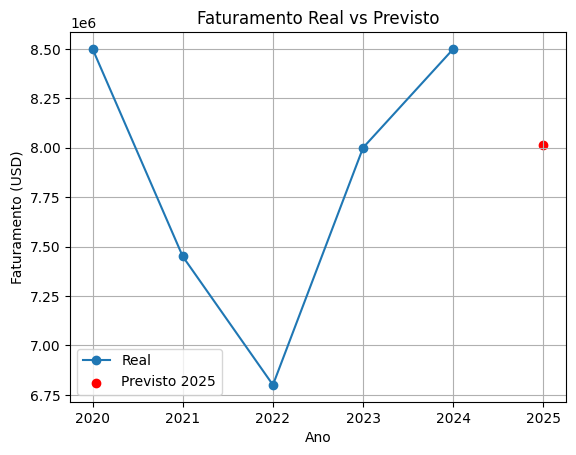

In [13]:
import matplotlib.pyplot as plt

years = df['year']
actual = df['revenue']
pred_2025 = predicted_revenue_2025

plt.figure()
plt.plot(years, actual, marker='o', label='Real')
plt.scatter([2025], [pred_2025], color='red', label='Previsto 2025')
plt.title("Faturamento Real vs Previsto")
plt.xlabel("Ano")
plt.ylabel("Faturamento (USD)")
plt.legend()
plt.grid(True)
plt.show()

2) Correlação com Variáveis Externas (Seaborn)

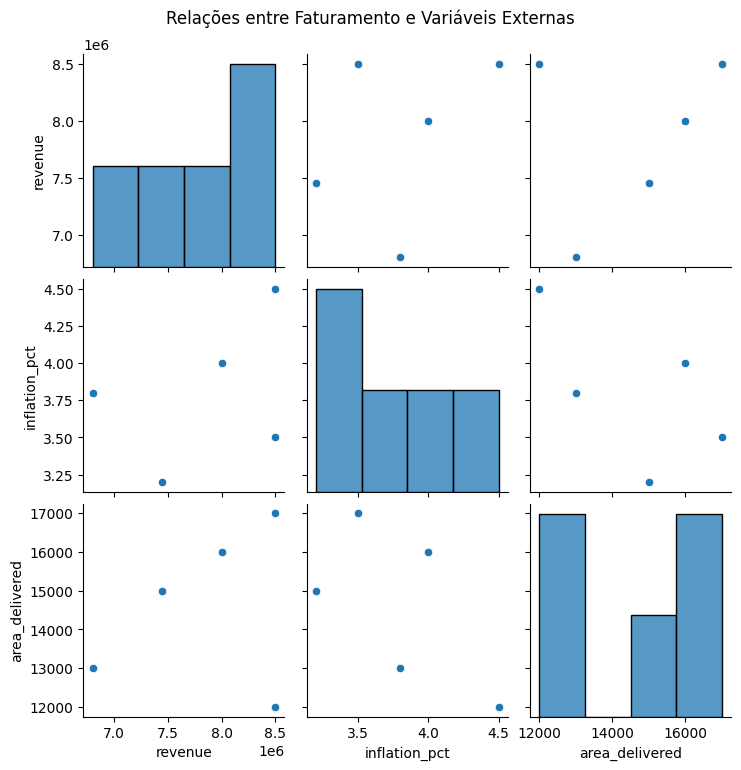

In [14]:
import seaborn as sns

sns.pairplot(df_full, vars=['revenue','inflation_pct','area_delivered'])
plt.suptitle("Relações entre Faturamento e Variáveis Externas", y=1.02)
plt.show()
